In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import glob
import calendar
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectFromModel

pd.options.display.max_columns = None
pd.options.display.max_rows = None

warnings.filterwarnings('ignore')

os.chdir("E:/Trinity/Dissertation/Sem 3/models/data/")

Read the new DataFrame

In [2]:
os.chdir("E:/Trinity/Dissertation/Sem 3/models/")
df = pd.read_csv("HourlyDetails (Unboosted).csv")  

In [3]:
print(len(df))
print(len(df[df["No_of_Cars"]<10]))
#print(len(df[df["isHoliday?"]==1])*100/len(df))

94392
16560


In [4]:
df = df[df["Tolls"]!="--"]
df = df[df["No_of_Cars"]>15]


### MODEL

In [5]:
# day of week ois important
# not keep isHoliday ---- 141.49
# keep isHoliday ---- 141.08
# Hyper parameter tuning ---- 141.06
df_x = df.drop(["No_of_Cars", "Date", "Tolls"],axis=1)
df_y = df["No_of_Cars"]

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, train_size=0.90, random_state=100)

In [25]:
from sklearn.ensemble import RandomForestRegressor
#rf = RandomForestRegressor(n_estimators=1500, random_state=123)

# From rf_random.best_estimator_

rf = RandomForestRegressor(bootstrap=True, 
                           ccp_alpha=0.0, 
                           criterion='mse', 
                           max_depth=100, 
                           max_features='auto', 
                           max_leaf_nodes=None, 
                           max_samples=None, 
                           min_impurity_decrease=0.0, 
                           min_impurity_split=None, 
                           min_samples_leaf=1, 
                           min_samples_split=2, 
                           min_weight_fraction_leaf=0.0, 
                           n_estimators=800, 
                           n_jobs=None, 
                           oob_score=True, 
                           random_state=100, 
                           verbose=0, 
                           warm_start=False)


In [26]:
model = rf.fit(x_train, y_train)        # Fit the RFR mode

In [27]:
from sklearn.metrics import mean_squared_error, r2_score
ypred = model.predict(x_test)

In [189]:
# Boosted
import math

mse = mean_squared_error(y_test, ypred)
rmse = math.sqrt(mse)
rmse
# 67.90514480712127

67.90514480712127

In [28]:
# UnBoosted
import math

mse = mean_squared_error(y_test, ypred)
rmse = math.sqrt(mse)
rmse

94.7278859034956

In [29]:
data = pd.DataFrame(ypred, y_test).reset_index()

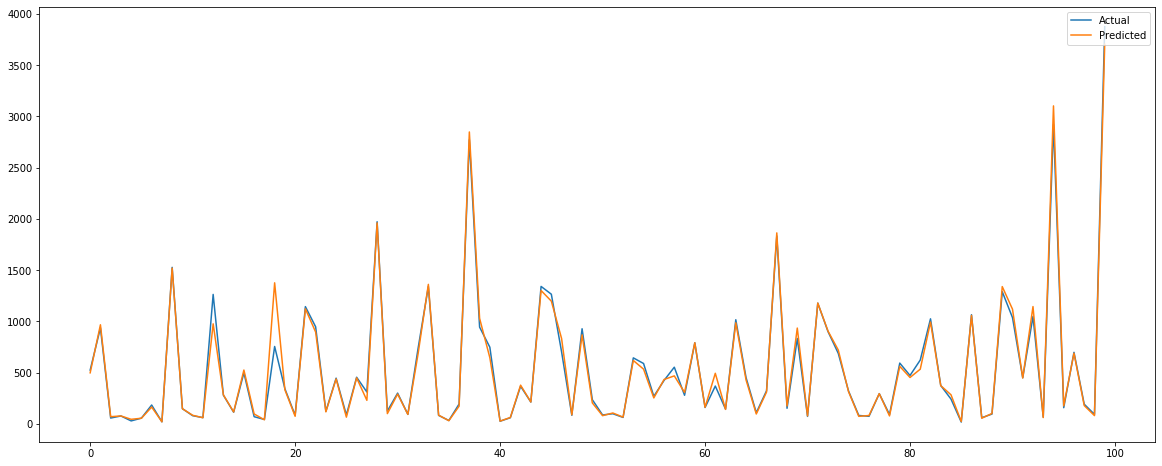

In [30]:
plt.figure(figsize=(20,8))
plt.plot(data["No_of_Cars"].head(100), label="Actual")
plt.plot(data[0].head(100), label="Predicted")
plt.legend(loc="upper right")
plt.show()

In [31]:
test = pd.DataFrame(y_test)
pred = pd.DataFrame(ypred)
final = pd.concat([test, pred], axis=1)
test.to_csv("test.csv")
pred.to_csv("pred.csv")
# manually merge the CSVs

In [32]:
data = pd.read_csv("test.csv")
data = data.set_index('Index')


In [33]:
merged = pd.merge(left=df, left_index=True,
                  right=data, right_index=True,
                  how='inner')

In [34]:
merged.head()

,Date,StartTime,EndTime,No_of_Cars_x,DayOfWeek,Weekend?,isHoliday?,Month,Day,Year,Tolls,Tollname_Dublin Tunnel,Tollname_Eastlink,Tollname_Limerick Tunnel,Tollname_M1,Tollname_M3,Tollname_M4,Tollname_M50,Tollname_M7-M8,Tollname_M8,Tollname_N25,Tollname_N6,No_of_Cars_y,Predicted
22,01-01-2019,22,23,144,2,0,1,-1.552307,-1.676356,2019,M7-M8,0,0,0,0,0,0,0,1,0,0,0,144,173.40000
23,01-01-2019,23,0,81,2,0,1,-1.552307,-1.676356,2019,M7-M8,0,0,0,0,0,0,0,1,0,0,0,81,72.03875
26,01-01-2019,2,3,23,2,0,1,-1.552307,-1.676356,2019,N6,0,0,0,0,0,0,0,0,0,0,1,23,25.85000
27,01-01-2019,3,4,17,2,0,1,-1.552307,-1.676356,2019,N6,0,0,0,0,0,0,0,0,0,0,1,17,34.58375
36,01-01-2019,12,13,349,2,0,1,-1.552307,-1.676356,2019,N6,0,0,0,0,0,0,0,0,0,0,1,349,188.73125


In [35]:
final = merged[["Date","Tolls","StartTime","DayOfWeek","isHoliday?","No_of_Cars_y","Predicted"]]

final["Inaccuracy"] = abs(final["No_of_Cars_y"] - final["Predicted"])
final["Precision"] = final["Inaccuracy"]/final["No_of_Cars_y"]

final = final.sort_values("Precision", ascending=False)

#final[(final["Precision"]>1) & (final["No_of_Cars_y"]>10)]

In [36]:
final.head()

,Date,Tolls,StartTime,DayOfWeek,isHoliday?,No_of_Cars_y,Predicted,Inaccuracy,Precision
91025,18-12-2019,M50,17,3,0,16,1213.73375,1197.73375,74.858359
93469,28-12-2019,M3,13,6,0,18,823.66625,805.66625,44.759236
93465,28-12-2019,M3,9,6,0,23,762.86625,739.86625,32.168098
67736,17-09-2019,M8,8,2,0,24,761.77750,737.77750,30.740729
67449,16-09-2019,M7-M8,9,1,0,32,927.55125,895.55125,27.985977


In [41]:
final.to_csv("RF_Predictions.csv", index=False)
#del(final)
del(test)
del(merged)
del(pred)
del(data)

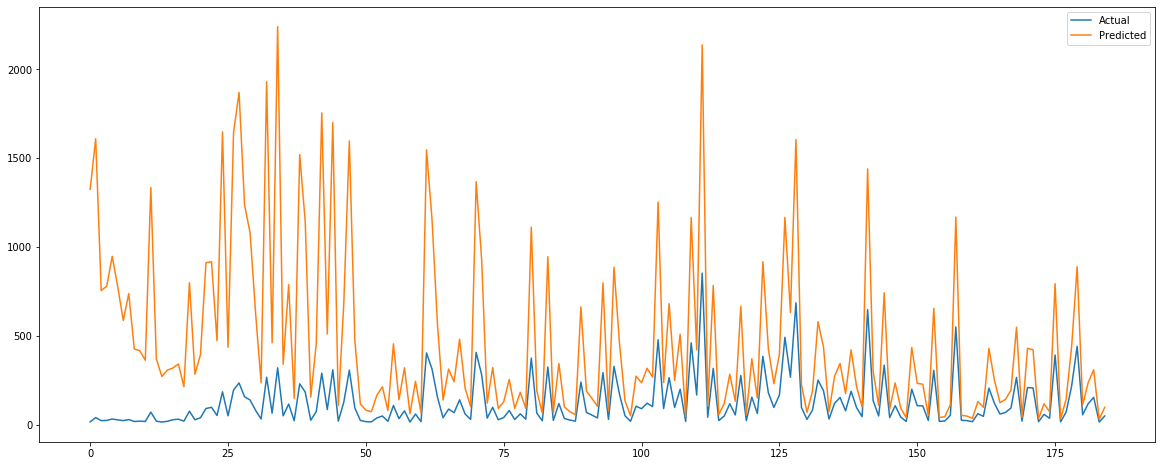

In [270]:
testing = final.reset_index()
plt.figure(figsize=(20,8))
plt.plot(testing[testing["Precision"]>=1].No_of_Cars_y, label="Actual")
plt.plot(testing[testing["Precision"]>=1].Predicted, label="Predicted")
plt.legend(loc="upper right")
plt.show()

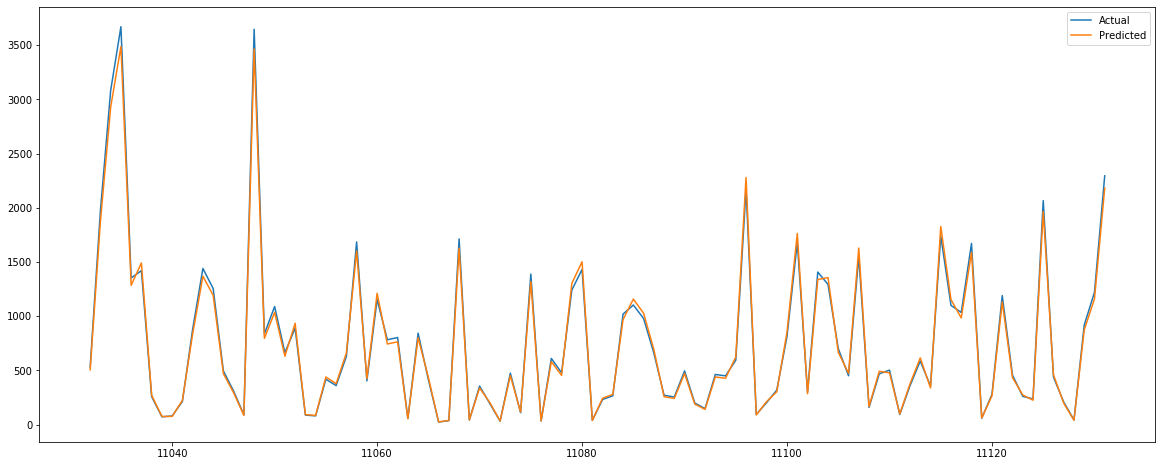

In [280]:
#testing = final.reset_index()
plt.figure(figsize=(20,8))
plt.plot(testing[testing["Precision"]<0.05].No_of_Cars_y.head(100), label="Actual")
plt.plot(testing[testing["Precision"]<0.05].Predicted.head(100), label="Predicted")
plt.legend(loc="upper right")
plt.show()

In [274]:
testing[testing["Precision"]<1].head()

,index,Date,StartTime,DayOfWeek,isHoliday?,No_of_Cars_y,Predicted,Inaccuracy,Precision
185,49513,06-07-2019,1,6,0,22,43.95250,21.95250,0.997841
186,39113,27-05-2019,17,1,0,1247,2489.50875,1242.50875,0.996398
187,92769,25-12-2019,9,3,1,80,159.34875,79.34875,0.991859
188,92792,25-12-2019,8,3,1,22,43.81875,21.81875,0.991761
189,93969,30-12-2019,9,1,0,765,1515.37500,750.37500,0.980882


### Grid Search

In [291]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [293]:
grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 32.1min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 45.2min finished


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}

In [ ]:
'''
best_params = {'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}
 '''

In [298]:
best_grid = grid_search.best_estimator_
model = best_grid.fit(x_train,y_train)

In [300]:
predictions = model.predict(x_test)

In [301]:
import math

mse = mean_squared_error(y_test, predictions)
rmse = math.sqrt(mse)
rmse

103.48378033004344

### Lazy Regressor

In [302]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime
import time
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils.testing import all_estimators
from sklearn.base import RegressorMixin
from sklearn.base import ClassifierMixin
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score, r2_score, mean_squared_error
import warnings
import xgboost
import lightgbm

warnings.filterwarnings("ignore")
pd.set_option("display.precision", 2)
pd.set_option("display.float_format", lambda x: '%.2f' % x)


REGRESSORS = [est for est in all_estimators(
) if issubclass(est[1], RegressorMixin)]

removed_regressors = [('TheilSenRegressor', sklearn.linear_model.theil_sen.TheilSenRegressor),
 ('ARDRegression', sklearn.linear_model.ARDRegression),
 ('CCA', sklearn.cross_decomposition.CCA),
 ('IsotonicRegression', sklearn.isotonic.IsotonicRegression),
 ('MultiOutputRegressor', sklearn.multioutput.MultiOutputRegressor),
 ('MultiTaskElasticNet',
  sklearn.linear_model.MultiTaskElasticNet),
 ('MultiTaskElasticNetCV',
  sklearn.linear_model.MultiTaskElasticNetCV),
 ('MultiTaskLasso', sklearn.linear_model.MultiTaskLasso),
 ('MultiTaskLassoCV',
  sklearn.linear_model.MultiTaskLassoCV),
 ('PLSCanonical', sklearn.cross_decomposition.PLSCanonical),
 ('PLSRegression', sklearn.cross_decomposition.PLSRegression),
 ('RadiusNeighborsRegressor',
  sklearn.neighbors.RadiusNeighborsRegressor),
 ('RegressorChain', sklearn.multioutput.RegressorChain),
 ('VotingRegressor', sklearn.ensemble.VotingRegressor),
 ('_SigmoidCalibration', sklearn.calibration._SigmoidCalibration),
 ('GaussianProcessRegressor',  sklearn.gaussian_process._gpr.GaussianProcessRegressor),
 ('KernelRidge', sklearn.kernel_ridge.KernelRidge),
 ('NuSVR', sklearn.svm._classes.NuSVR),
 ('MLPRegressor', sklearn.neural_network._multilayer_perceptron.MLPRegressor),
 ('OrthogonalMatchingPursuit', sklearn.linear_model._omp.OrthogonalMatchingPursuit),
 ('OrthogonalMatchingPursuitCV', sklearn.linear_model._omp.OrthogonalMatchingPursuitCV),
 ('PassiveAggressiveRegressor', sklearn.linear_model._passive_aggressive.PassiveAggressiveRegressor),
 ('SVR', sklearn.svm._classes.SVR)
]

for i in removed_regressors:
    REGRESSORS.pop(REGRESSORS.index(i))
    

REGRESSORS.append(('XGBRegressor', xgboost.XGBRegressor))
REGRESSORS.append(('LGBMRegressor',lightgbm.LGBMRegressor))
# REGRESSORS.append(('CatBoostRegressor',catboost.CatBoostRegressor))
    
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoding', OneHotEncoder(handle_unknown='ignore', sparse=False))
])



class LazyRegressor:
 
    def __init__(self, verbose=0, ignore_warnings=True, custom_metric = None, predictions = False,random_state=100):
        self.verbose = verbose
        self.ignore_warnings = ignore_warnings
        self.custom_metric = custom_metric
        self.predictions = predictions
        self.random_state = random_state

    def fit(self, X_train, X_test, y_train, y_test):

        R2 = []
        RMSE = []
        # WIN = []
        names = []
        TIME = []
        predictions = {}
        
        if self.custom_metric != None:
            CUSTOM_METRIC = []

        if type(X_train) is np.ndarray:
            X_train = pd.DataFrame(X_train)
            X_test = pd.DataFrame(X_test)

        numeric_features = X_train.select_dtypes(
            include=['int64', 'float64', 'int32', 'float32']).columns
        categorical_features = X_train.select_dtypes(
            include=['object']).columns

        preprocessor = ColumnTransformer(
            transformers=[
                ('numeric', numeric_transformer, numeric_features),
                ('categorical', categorical_transformer, categorical_features)
            ])
        
        print(REGRESSORS)
        for name, model in tqdm(REGRESSORS):
            start = time.time()
            try:
                if 'random_state' in model().get_params().keys():
                    pipe = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('regressor', model(random_state = self.random_state))
                    ])
                else:
                    pipe = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('regressor', model())
                ])
                pipe.fit(X_train, y_train)
                y_pred = pipe.predict(X_test)
                r_squared = r2_score(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                names.append(name)
                R2.append(r_squared)
                RMSE.append(rmse)
                TIME.append(time.time() - start)
                if self.custom_metric != None:
                    custom_metric = self.custom_metric(y_test, y_pred)
                    CUSTOM_METRIC.append(custom_metric)

                if self.verbose > 0:
                    if self.custom_metric != None:
                        print({"Model": name,
                               "R-Squared": r_squared,
                               "RMSE": rmse,
                               self.custom_metric.__name__: custom_metric,
                               "Time taken": time.time() - start})
                    else:
                        print({"Model": name,
                               "R-Squared": r_squared,
                               "RMSE": rmse,
                               "Time taken": time.time() - start})
                if self.predictions == True:
                    predictions[name]=y_pred
            except Exception as exception:
                if self.ignore_warnings == False:
                    print(name + " model failed to execute")
                    print(exception)
                    
        if self.custom_metric == None:
            scores = pd.DataFrame({"Model": names, 
                                   "R-Squared": R2, 
                                   "RMSE": RMSE,
                                   "Time Taken": TIME})
        else:
            scores = pd.DataFrame({"Model": names, 
                                   "R-Squared": R2, 
                                   "RMSE": RMSE,
                                   self.custom_metric.__name__: CUSTOM_METRIC,
                                   "Time Taken": TIME})
        scores = scores.sort_values(
            by='R-Squared', ascending=False).set_index('Model')
        
        if self.predictions == True:
            predictions_df = pd.DataFrame.from_dict(predictions)
        return scores, predictions_df if self.predictions == True else scores

Regression = LazyRegressor


In [304]:
from sklearn.utils import shuffle
X, y = shuffle(df_x, df_y, random_state=100)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]
reg = LazyRegressor(verbose=2,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

  0%|                                                                                                                                                                                      | 0/31 [00:00<?, ?it/s]

[('AdaBoostRegressor', <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>), ('BaggingRegressor', <class 'sklearn.ensemble._bagging.BaggingRegressor'>), ('BayesianRidge', <class 'sklearn.linear_model._bayes.BayesianRidge'>), ('DecisionTreeRegressor', <class 'sklearn.tree._classes.DecisionTreeRegressor'>), ('DummyRegressor', <class 'sklearn.dummy.DummyRegressor'>), ('ElasticNet', <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>), ('ElasticNetCV', <class 'sklearn.linear_model._coordinate_descent.ElasticNetCV'>), ('ExtraTreeRegressor', <class 'sklearn.tree._classes.ExtraTreeRegressor'>), ('ExtraTreesRegressor', <class 'sklearn.ensemble._forest.ExtraTreesRegressor'>), ('GradientBoostingRegressor', <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>), ('HistGradientBoostingRegressor', <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor'>), ('HuberRegressor', <class 'sklearn.linear_model._huber.HuberRegressor'>), ('KNei

  3%|█████▌                                                                                                                                                                        | 1/31 [00:02<01:29,  2.99s/it]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.7273817212534843, 'RMSE': 394.0773718182529, 'Time taken': 2.9876692295074463}


 10%|████████████████▊                                                                                                                                                             | 3/31 [00:04<00:52,  1.87s/it]

{'Model': 'BaggingRegressor', 'R-Squared': 0.9856540213435732, 'RMSE': 90.40013990055975, 'Time taken': 1.756303071975708}
{'Model': 'BayesianRidge', 'R-Squared': 0.4729120466520491, 'RMSE': 547.9558371241408, 'Time taken': 0.12764835357666016}


 19%|█████████████████████████████████▋                                                                                                                                            | 6/31 [00:05<00:25,  1.01s/it]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9780200546902236, 'RMSE': 111.89670963799482, 'Time taken': 0.3500516414642334}
{'Model': 'DummyRegressor', 'R-Squared': -0.00022588624260766466, 'RMSE': 754.8367871066484, 'Time taken': 0.05987405776977539}
{'Model': 'ElasticNet', 'R-Squared': 0.42749783502290983, 'RMSE': 571.0742513109822, 'Time taken': 0.06481742858886719}


 23%|███████████████████████████████████████▎                                                                                                                                      | 7/31 [00:06<00:22,  1.07it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.4430379431494311, 'RMSE': 563.2702543932293, 'Time taken': 0.7669479846954346}


 26%|████████████████████████████████████████████▉                                                                                                                                 | 8/31 [00:06<00:16,  1.36it/s]

{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.9694047624772619, 'RMSE': 132.01732449792402, 'Time taken': 0.254810094833374}


 29%|██████████████████████████████████████████████████▌                                                                                                                           | 9/31 [00:21<01:52,  5.10s/it]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9843171197934464, 'RMSE': 94.51852266709085, 'Time taken': 15.293948650360107}


 32%|███████████████████████████████████████████████████████▊                                                                                                                     | 10/31 [00:26<01:45,  5.01s/it]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9065194531007656, 'RMSE': 230.76218084516705, 'Time taken': 4.7906494140625}


 35%|█████████████████████████████████████████████████████████████▍                                                                                                               | 11/31 [00:28<01:20,  4.02s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9817893720779927, 'RMSE': 101.85127568279715, 'Time taken': 1.6970016956329346}


 39%|██████████████████████████████████████████████████████████████████▉                                                                                                          | 12/31 [00:28<00:56,  3.00s/it]

{'Model': 'HuberRegressor', 'R-Squared': 0.4431235228442981, 'RMSE': 563.2269782420474, 'Time taken': 0.6263241767883301}


 45%|██████████████████████████████████████████████████████████████████████████████▏                                                                                              | 14/31 [00:44<01:22,  4.87s/it]

{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9532850833173048, 'RMSE': 163.12923580551197, 'Time taken': 16.021097421646118}
{'Model': 'Lars', 'R-Squared': 0.47291088110963453, 'RMSE': 547.9564429674467, 'Time taken': 0.10761690139770508}


 48%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 15/31 [00:45<00:57,  3.61s/it]

{'Model': 'LarsCV', 'R-Squared': 0.47291109383232954, 'RMSE': 547.9563323952693, 'Time taken': 0.6632266044616699}
{'Model': 'Lasso', 'R-Squared': 0.47285137937507327, 'RMSE': 547.9873707911756, 'Time taken': 0.08975863456726074}


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 18/31 [00:46<00:24,  1.88s/it]

{'Model': 'LassoCV', 'R-Squared': 0.472904618026993, 'RMSE': 547.9596984760207, 'Time taken': 0.724064826965332}
{'Model': 'LassoLars', 'R-Squared': 0.1154916596141492, 'RMSE': 709.8310269696303, 'Time taken': 0.0967404842376709}


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 19/31 [00:47<00:18,  1.54s/it]

{'Model': 'LassoLarsCV', 'R-Squared': 0.47291109383232954, 'RMSE': 547.9563323952693, 'Time taken': 0.740020751953125}


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 21/31 [00:47<00:08,  1.19it/s]

{'Model': 'LassoLarsIC', 'R-Squared': 0.47290068641215854, 'RMSE': 547.9617420933009, 'Time taken': 0.204453706741333}
{'Model': 'LinearRegression', 'R-Squared': 0.47293744491276923, 'RMSE': 547.9426350648044, 'Time taken': 0.14760494232177734}


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 22/31 [00:47<00:06,  1.49it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.42680198595047847, 'RMSE': 571.4212026730318, 'Time taken': 0.26130151748657227}


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 23/31 [00:48<00:05,  1.56it/s]

{'Model': 'RANSACRegressor', 'R-Squared': 0.1455009754925941, 'RMSE': 697.6856620905425, 'Time taken': 0.5814461708068848}


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 25/31 [01:07<00:25,  4.26s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9869131710601248, 'RMSE': 86.34182523587701, 'Time taken': 18.53026270866394}
{'Model': 'Ridge', 'R-Squared': 0.4729109535903566, 'RMSE': 547.9564052923376, 'Time taken': 0.1745302677154541}


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 26/31 [01:07<00:15,  3.04s/it]

{'Model': 'RidgeCV', 'R-Squared': 0.47291152180048823, 'RMSE': 547.9561099395248, 'Time taken': 0.2014613151550293}


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 27/31 [01:07<00:08,  2.22s/it]

{'Model': 'SGDRegressor', 'R-Squared': 0.4720234325651922, 'RMSE': 548.4175401674618, 'Time taken': 0.28523707389831543}
StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.47293744491276923, 'RMSE': 547.9426350648044, 'Time taken': 0.08178162574768066}
[02:43:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 30/31 [01:13<00:02,  2.12s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9050383986459561, 'RMSE': 232.58303168793884, 'Time taken': 5.614404916763306}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:14<00:00,  2.40s/it]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9817893720779927, 'RMSE': 101.85127568279715, 'Time taken': 0.9170932769775391}


In [305]:
models

,R-Squared,RMSE,Time Taken
Model,,,
RandomForestRegressor,0.99,86.34,18.53
BaggingRegressor,0.99,90.40,1.76
ExtraTreesRegressor,0.98,94.52,15.29
LGBMRegressor,0.98,101.85,0.92
HistGradientBoostingRegressor,0.98,101.85,1.70
DecisionTreeRegressor,0.98,111.90,0.35
ExtraTreeRegressor,0.97,132.02,0.25
KNeighborsRegressor,0.95,163.13,16.02
GradientBoostingRegressor,0.91,230.76,4.79


### Find the inaccuracies

In [43]:
data = pd.read_csv("RF_Predictions.csv")

In [44]:
data.head()

,Date,Tolls,StartTime,DayOfWeek,isHoliday?,No_of_Cars_y,Predicted,Inaccuracy,Precision
0,15-08-2019,M1,6,4,0,40,1573.65125,1533.65125,38.341281
1,28-12-2019,M3,9,6,0,23,823.11125,800.11125,34.787446
2,28-12-2019,M50,20,6,0,29,774.63875,745.63875,25.711681
3,14-11-2019,M8,14,4,0,15,341.32500,326.32500,21.755000
4,28-12-2019,M4,8,6,0,20,454.78625,434.78625,21.739313


In [60]:
verybadpreds = data[data["Precision"]>0.5]

In [67]:
verybadpreds["DayOfWeek"].value_counts()

7    41
2    32
3    30
1    30
6    23
4    23
5    21
Name: DayOfWeek, dtype: int64

In [69]:
data["isHoliday?"].value_counts()

0    7487
1     165
Name: isHoliday?, dtype: int64

In [66]:
print(176/7487)
print(24/165)

0.02350741284893816
0.14545454545454545


In [71]:
len(verybadpreds[verybadpreds["isHoliday?"]==1])

24

### Each toll separately

In [6]:
df.head()

,Date,StartTime,EndTime,No_of_Cars,DayOfWeek,Weekend?,isHoliday?,Month,Day,Year,Tolls,Tollname_Dublin Tunnel,Tollname_Eastlink,Tollname_Limerick Tunnel,Tollname_M1,Tollname_M3,Tollname_M4,Tollname_M50,Tollname_M7-M8,Tollname_M8,Tollname_N25,Tollname_N6
0,01-01-2019,0,1,22,2,0,1,-1.552307,-1.676356,2019,M7-M8,0,0,0,0,0,0,0,1,0,0,0
1,01-01-2019,1,2,29,2,0,1,-1.552307,-1.676356,2019,M7-M8,0,0,0,0,0,0,0,1,0,0,0
2,01-01-2019,2,3,25,2,0,1,-1.552307,-1.676356,2019,M7-M8,0,0,0,0,0,0,0,1,0,0,0
3,01-01-2019,3,4,31,2,0,1,-1.552307,-1.676356,2019,M7-M8,0,0,0,0,0,0,0,1,0,0,0
4,01-01-2019,4,5,24,2,0,1,-1.552307,-1.676356,2019,M7-M8,0,0,0,0,0,0,0,1,0,0,0
